# 数据挖掘

# 目录
1. 组群划分
2. 用户地理位置分析
3. 新用户预测

## 1. 组群划分
### 导入库

In [10]:
import networkx as nx
import pandas as pd
import numpy as np
import community.community_louvain as community
import matplotlib.pyplot as plt

### 读取数据

In [11]:
node_edge = pd.read_csv('douban_edges.csv')
node_list = pd.read_csv('douban_info.csv') #, index_col='userId'

### 数据预处理

In [12]:
#去除url部分
node_edge = node_edge[['userId', 'friendId']]
node_edge

,userId,friendId
0,67007418,67007418
1,67007418,196094934
2,67007418,157079038
3,67007418,tjz230
4,67007418,joearde
...,...,...
95391,Tirisfal,kaisic
95392,Tirisfal,xuuss
95393,Tirisfal,4513498
95394,Tirisfal,45046918


In [13]:
#去除node_list中的空值
node_list = node_list.dropna()
node_list

,userId,city,joinDate
0,67007418,北京,2012-12-09
1,196094934,广东广州,2019-05-07
2,157079038,江苏南京,2017-01-31
3,tjz230,北京,2005-07-18
4,joearde,北京,2005-08-24
...,...,...,...
15555,135179506,广东广州,2015-09-27
15556,2159161,北京,2008-01-08
15557,64354416,"Bristol, United Kingdom",2012-09-01
15558,1602355,北京,2007-06-09


In [14]:
#在node_edge中去除 node_list中不存在 的用户
#node_edge.drop(node_edge[node_edge['friendId'] == node_list['userId']].index)
node_edge = node_edge[node_edge['friendId'].isin(node_list['userId'])]

node_edge.groupby('friendId').count()

,userId
friendId,
100036482,1
100092785,1
1001709,1
100190573,1
1002602,1
...,...
zzy1217,3
zzzazxzl,1
zzzcounseling,1


In [15]:
node_edge = node_edge[node_edge['userId'].isin(node_list['userId'])]
node_edge.groupby('friendId').count()

,userId
friendId,
100036482,1
100092785,1
1001709,1
1002602,1
1002971,3
...,...
zzy1217,3
zzzazxzl,1
zzzcounseling,1


In [16]:
node_list = node_list[node_list['userId'].isin(node_edge['friendId'])]
node_list

,userId,city,joinDate
0,67007418,北京,2012-12-09
1,196094934,广东广州,2019-05-07
2,157079038,江苏南京,2017-01-31
3,tjz230,北京,2005-07-18
4,joearde,北京,2005-08-24
...,...,...,...
15555,135179506,广东广州,2015-09-27
15556,2159161,北京,2008-01-08
15557,64354416,"Bristol, United Kingdom",2012-09-01
15558,1602355,北京,2007-06-09


In [17]:
#将userId设置为index
node_list = node_list.set_index('userId')

### 用nx生成一个Graph

In [18]:
#返回根据DataFrame里 的数据返回一个Graph
G_edge = nx.from_pandas_edgelist(node_edge, source='userId', target='friendId')

In [19]:
len(G_edge.nodes)

13303

In [20]:
node_list.shape

(13303, 2)

In [21]:
node_list.groupby('city').count()

,joinDate
city,
"'Ammān, Jordan",2
"Aarhus, Denmark",2
"Abidjan, Côte d'Ivoire",3
"Adelaide, Australia",10
"Aix-en-Provence, France",2
...,...
黑龙江佳木斯,1
黑龙江哈尔滨,37
黑龙江大兴安岭,1


#### 注意：DataFrame 数据处理字符转数值

In [22]:
#将城市名改为数字
cityNum = node_list['city'].unique()
def conver(x):
    return np.argwhere(cityNum==x)[0,0]

node_list['cityNum'] = node_list['city'].map(conver)
node_list

,city,joinDate,cityNum
userId,,,
67007418,北京,2012-12-09,0
196094934,广东广州,2019-05-07,1
157079038,江苏南京,2017-01-31,2
tjz230,北京,2005-07-18,0
joearde,北京,2005-08-24,0
...,...,...,...
135179506,广东广州,2015-09-27,1
2159161,北京,2008-01-08,0
64354416,"Bristol, United Kingdom",2012-09-01,526


In [23]:
values = [node_list.loc[node, 'cityNum'] for node in G_edge]

In [24]:
max(values)

637

In [25]:
len(values)

13303

### 根据 用户所在城市 画图

C:\Users\ARCHER\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


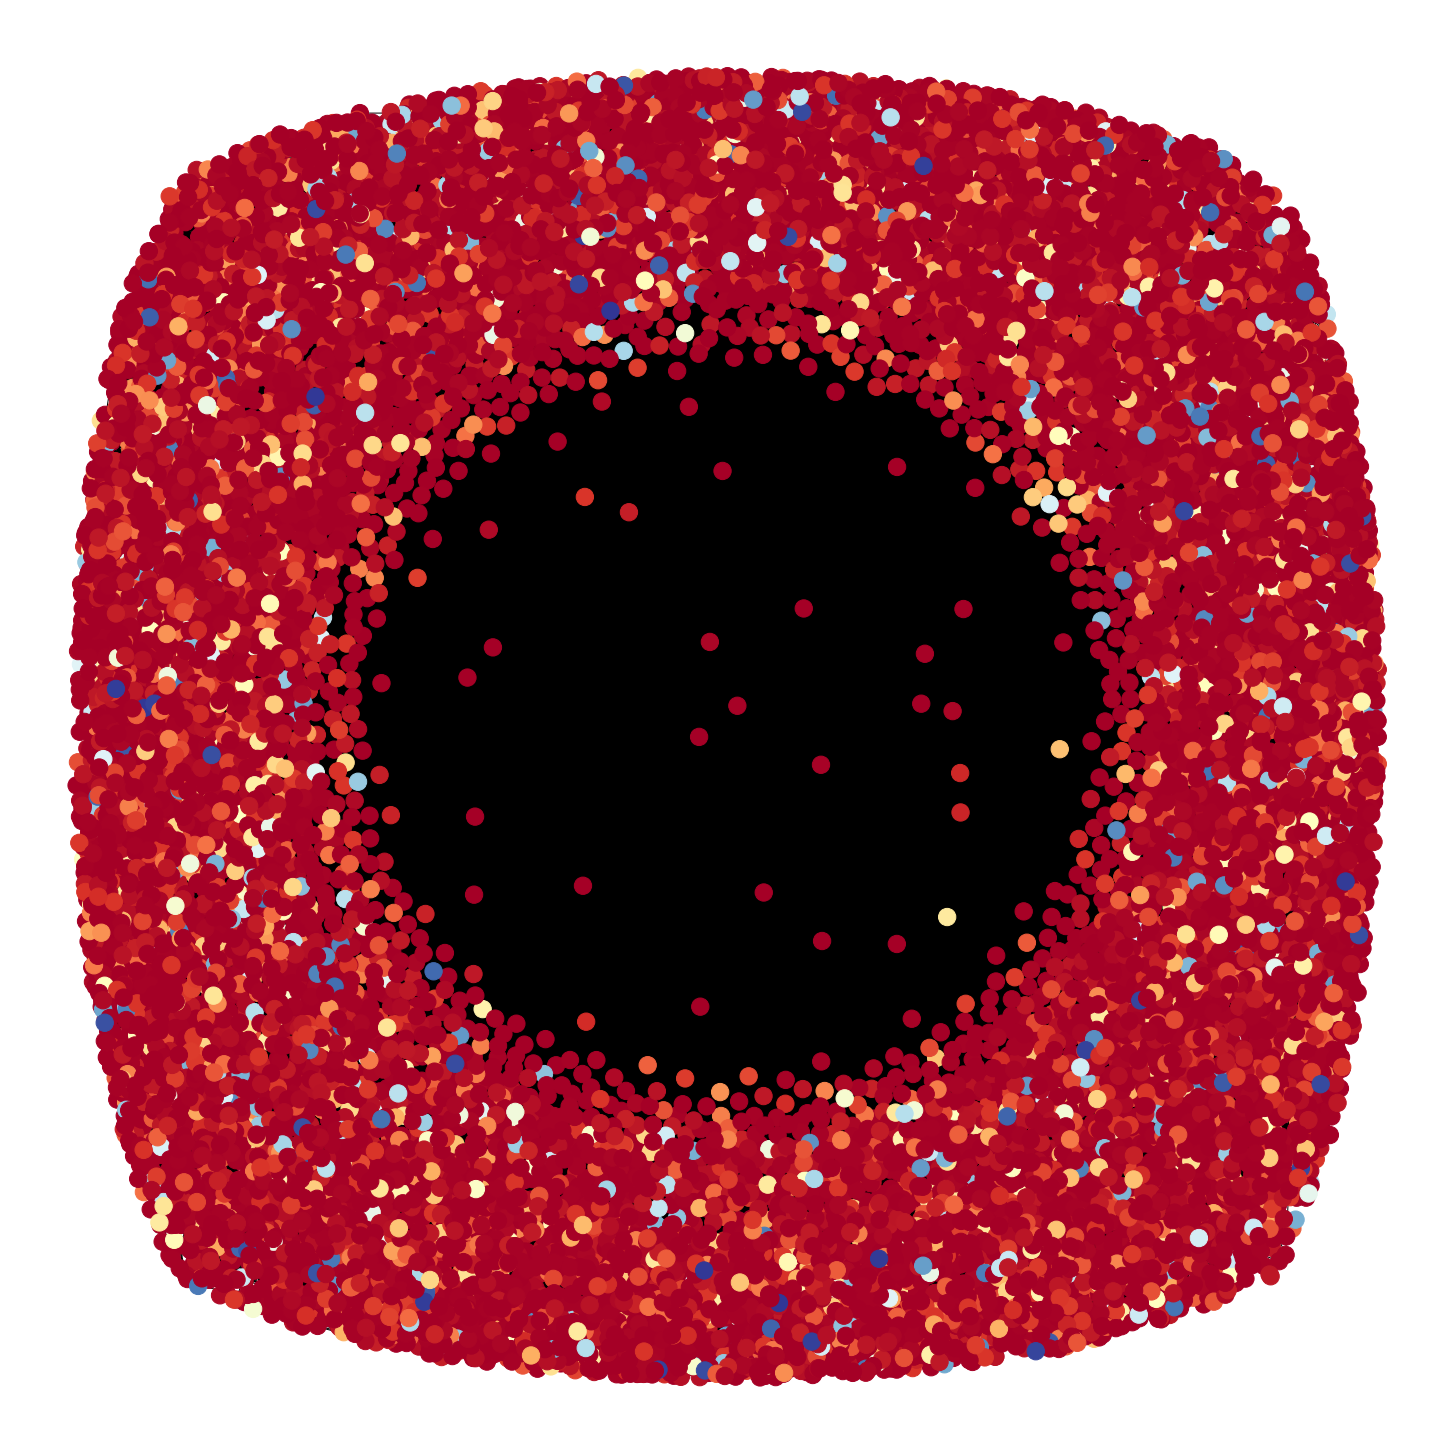

In [32]:
plt.figure(figsize = (20, 20))
nx.draw(G_edge, cmap=plt.cm.RdYlBu, pos=nx.spring_layout(G_edge, k=0.6, iterations=10), node_edge='gray', node_color = values)

### 使用louvain进行组群划分
#### 注意：这里直接调用community会出错
module ‘community’ has no attribute ‘best_partition’
#### 解决方式：pip安装community python-louvain，然后进一步加载import community.community_louvain即可解决
import community.community_louvain as community

In [26]:
#组群划分
parts = community.best_partition(G_edge)

In [27]:
print(list(parts.values()))

[0, 0, 0, 1, 2, 0, 3, 0, 3, 0, 4, 0, 5, 6, 7, 0, 8, 3, 8, 0, 9, 4, 10, 9, 5, 0, 0, 1, 2, 0, 11, 3, 8, 3, 3, 3, 0, 4, 3, 3, 3, 0, 2, 0, 3, 3, 3, 5, 1, 1, 3, 3, 1, 4, 4, 0, 8, 8, 0, 6, 7, 0, 12, 6, 3, 3, 0, 0, 0, 0, 7, 3, 0, 3, 1, 10, 0, 1, 7, 1, 1, 1, 3, 1, 8, 1, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 7, 3, 3, 1, 1, 4, 1, 1, 1, 11, 7, 7, 3, 1, 4, 13, 1, 3, 1, 3, 1, 1, 1, 1, 7, 7, 7, 3, 1, 1, 1, 1, 1, 3, 1, 7, 1, 1, 1, 1, 3, 10, 0, 3, 1, 0, 3, 1, 1, 2, 1, 3, 0, 7, 1, 1, 3, 1, 1, 2, 1, 2, 2, 3, 7, 0, 1, 1, 1, 2, 9, 1, 1, 2, 1, 1, 1, 7, 3, 1, 1, 1, 2, 1, 3, 3, 1, 0, 1, 1, 1, 2, 3, 1, 1, 1, 7, 7, 7, 1, 0, 7, 2, 3, 1, 3, 1, 2, 2, 1, 0, 7, 7, 7, 7, 7, 9, 1, 1, 1, 3, 1, 7, 1, 3, 4, 1, 1, 7, 7, 7, 1, 1, 14, 7, 1, 0, 2, 2, 1, 7, 2, 2, 11, 13, 1, 1, 2, 2, 2, 1, 1, 13, 5, 1, 11, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 1, 7, 7, 1, 1, 2, 2, 2, 7, 1, 3, 1, 1, 2, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 7, 7, 7, 7, 2, 1, 5, 2, 2, 5, 1, 7, 3, 2, 2, 2, 7, 2, 13, 2, 2, 3, 1, 1, 2, 11, 7, 1, 7, 1, 7

In [28]:
node_list['detectedCommunity'] = list(parts.values())

In [29]:
#城市的个数
len(node_list['cityNum'].unique())

638

In [30]:
#组群划分的个数
len(node_list['detectedCommunity'].unique())

15

In [31]:
node_list.head()

,city,joinDate,cityNum,detectedCommunity
userId,,,,
67007418,北京,2012-12-09,0,0
196094934,广东广州,2019-05-07,1,0
157079038,江苏南京,2017-01-31,2,0
tjz230,北京,2005-07-18,0,1
joearde,北京,2005-08-24,0,2


### 根据 louvain划分后的群组 画图

C:\Users\ARCHER\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


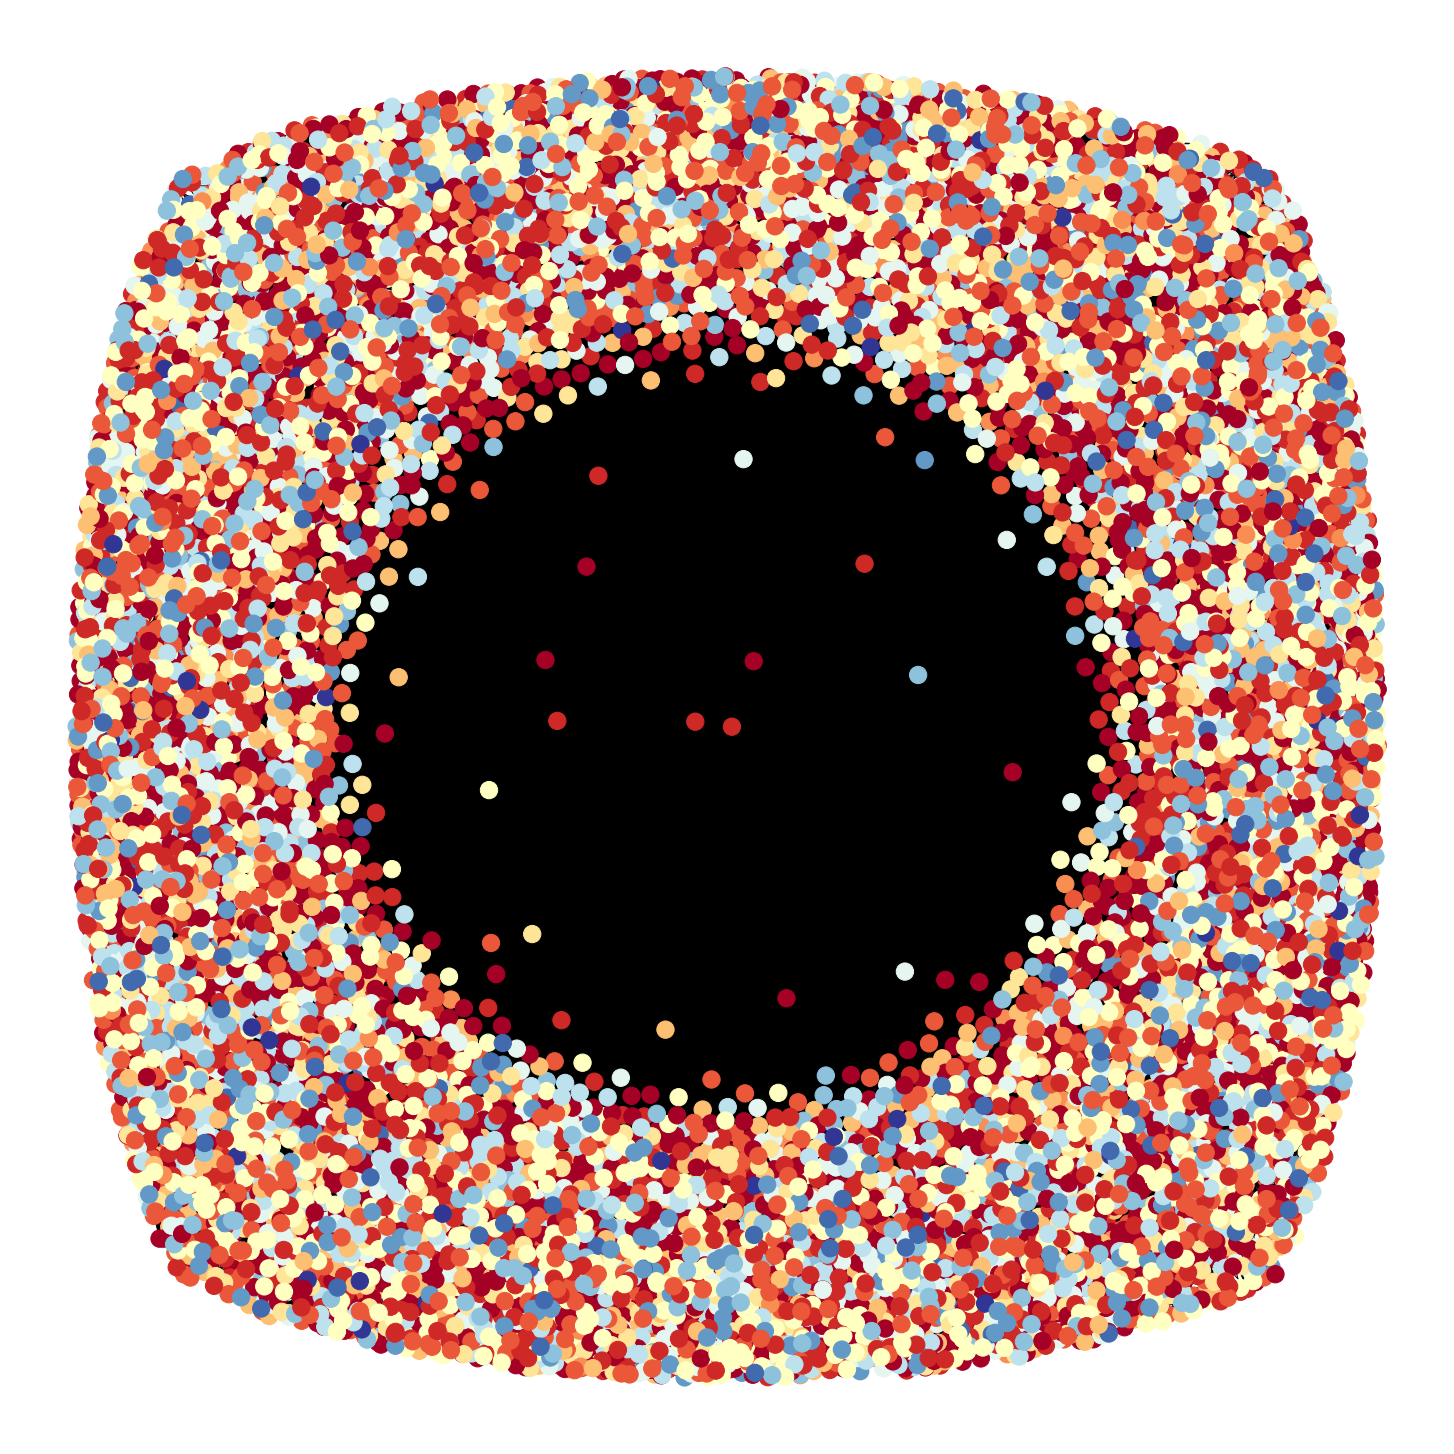

In [82]:
plt.figure(figsize=(20, 20))
values1 = [node_list.loc[node, 'detectedCommunity'] for node in G_edge]
nx.draw(G_edge, cmap=plt.cm.RdYlBu, pos=nx.spring_layout(G_edge, k=0.6, iterations=10), node_edge='gray', node_color = values1)

### 计算各城市所有的用户量

In [33]:
node_list.groupby('cityNum').count()['city']

cityNum
0      4194
1       478
2       275
3      2093
4       476
       ... 
633       1
634       1
635       1
636       1
637       1
Name: city, Length: 638, dtype: int64

#### 创建城市df

In [34]:
#用unique得出各城市名
city_node = pd.DataFrame(node_list['city'].unique(), columns=['cityName'])

In [35]:
#couny计算各个城市的用户数 并添加进df
city_node['userNumInCity'] = node_list.groupby('cityNum').count()['city']

In [37]:
#用户数降序排序显示
city_node.sort_values('userNumInCity', ascending=False)

,cityName,userNumInCity
0,北京,4194
3,上海,2093
10,浙江杭州,492
1,广东广州,478
4,广东深圳,476
...,...,...
436,中国台湾台南,1
438,"Weimar, Germany",1
440,"Kagoshima, Japan",1
441,安徽亳州,1


**可以看出豆瓣大多数用户都是来自北京，上海，杭州，广州和深圳的年轻人**

#### 创建根据louvain划分的群组community_node

In [104]:
#查看0号群组用户分布情况
community_node = node_list.loc[node_list['detectedCommunity'] == 0]
community_node.groupby('cityNum').count().sort_values('city', ascending = False)

,city,joinDate,detectedCommunity
cityNum,,,
0,826,826,826
3,425,425,425
4,126,126,126
1,94,94,94
10,93,93,93
...,...,...,...
288,1,1,1
290,1,1,1
295,1,1,1


**0号组群里最多的是北京用户826位，第二多的是上海用户425位**

## 2. 用户地理位置分析
### 导入库：此处用echarts
#### 注意：一定要导入Map库， 不然地图会显示不出来

In [145]:
from pyecharts import Geo, Map

### 数据准备和预处理：

In [138]:
#读取经纬度数据
jiWei = pd.read_csv('中国省市经纬度.csv')
jiWei.loc[0:5, 'city'] =jiWei.loc[0:5, 'province']

In [139]:
#使用str.strip修改城市名， 使其标准化
jiWei['cityName'] = jiWei['city'].str.strip('市')
jiWei.loc[6:, 'city'] = jiWei.loc[6:, 'province'].str.strip('省')+jiWei.loc[6:, 'city']

jiWei.loc[:, 'city'] = jiWei['city'].str.strip('市')


jiWei.head(10)

,province,city,longitude,latitude,cityName
0,北京市,北京,116.40717,39.90469,北京
1,天津市,天津,117.19937,39.08510,天津
2,上海市,上海,121.47370,31.23037,上海
3,重庆市,重庆,106.55073,29.56471,重庆
4,香港,香港,114.16546,22.27534,香港
5,澳门,澳门,113.54913,22.19875,澳门
6,河北省,河北石家庄,114.51430,38.04276,石家庄
7,河北省,河北唐山,118.18058,39.63048,唐山
8,河北省,河北秦皇岛,119.59964,39.93545,秦皇岛
9,河北省,河北邯郸,114.53918,36.62556,邯郸


In [140]:
#将经纬表和用户表Merge, 以城市名为Key
node_list_all = pd.merge(city_node, jiWei, left_on = 'cityName', right_on='city', how='inner')
node_list_all['city'] = node_list_all['cityName_y']
node_list_all

,cityName_x,userNumInCity,province,city,longitude,latitude,cityName_y
0,北京,4194,北京市,北京,116.40717,39.90469,北京
1,广东广州,478,广东省,广州,113.26436,23.12908,广州
2,江苏南京,275,江苏省,南京,118.79647,32.05838,南京
3,上海,2093,上海市,上海,121.47370,31.23037,上海
4,广东深圳,476,广东省,深圳,114.05956,22.54286,深圳
...,...,...,...,...,...,...,...
190,河南平顶山,1,河南省,平顶山,113.19241,33.76609,平顶山
191,江西鹰潭,1,江西省,鹰潭,117.06919,28.26019,鹰潭
192,广东湛江,1,广东省,湛江,110.35894,21.27134,湛江
193,安徽淮南,1,安徽省,淮南,116.99980,32.62549,淮南


In [146]:
geoG = Geo("China",#设置地图标题
           title_color="#fff",#设置标题颜色为白色
           title_pos="center",#标题位置在中间
           width=1200,#图片宽度
           height=600,#图片长度
           background_color='#404a59'#设置图片背景颜色
          )


In [147]:
attr = list(node_list_all['city'])
value = list(node_list_all['userNumInCity'])
geo_cities_coords = {node_list_all.iloc[i]['city']:[node_list_all.iloc[i]['longitude'], node_list_all.iloc[i]['latitude']] for i in range(len(node_list_all))}
#geo_cities_coords
#value

In [152]:
geoG.add("", #标题，构建坐标系的时候已经写好，不需要设置，设为空
        attr,#城市名
        value,#各城市的用户数
        visual_range=[0, 5000],#可视化深浅的范围
        visual_text_color="#fff",#标签的颜色
        is_piecewise=True,#设置颜色分段显示
        visual_split_number=10,#设置10个不同的组
        symbol_size=7.5,#设置散点大小为7.5
        is_visualmap=True,#设置颜色与value一一对应，value越高，颜色越深
        geo_cities_coords=geo_cities_coords#设置散点所在的经纬度
        )
        

#### html文件保存在根目录中，用浏览器打开即可

In [150]:
geoG.render(path='China.html')

## 3. 每月新增用户量预测
### ARIMA模型（Autoregressive Integrated Moving Average model）
差分整合移动平均自回归模型，又称整合移动平均自回归模型（移动也可称作滑动），是时间序列预测分析方法之一。
### 添加库

In [114]:
import matplotlib.pyplot as plt
from random import randrange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa

### 数据预处理

In [50]:
#读取数据
node_date = pd.read_csv('douban_info.csv', index_col='userId')

In [54]:
node_date['number'] = 1

In [56]:
node_date.head()

,city,joinDate,number
userId,,,
67007418,北京,2012-12-09,1
196094934,广东广州,2019-05-07,1
157079038,江苏南京,2017-01-31,1
tjz230,北京,2005-07-18,1
joearde,北京,2005-08-24,1


In [57]:
#将数据类型转换为日期类型
node_date['joinDate'] = pd.to_datetime(node_date['joinDate'])

In [59]:
#将日期数据作为索引
node_date = node_date.set_index('joinDate')
node_date

,city,number
joinDate,,
2012-12-09,北京,1
2019-05-07,广东广州,1
2017-01-31,江苏南京,1
2005-07-18,北京,1
2005-08-24,北京,1
...,...,...
2008-01-08,北京,1
2012-09-01,"Bristol, United Kingdom",1
2007-06-09,北京,1


In [153]:
#将数据按月度统计并显示
userJoinMonth = node_date.resample('M').sum().to_period('M')
userJoinMonth.head()

,number
joinDate,
2005-03,6
2005-04,19
2005-05,17
2005-06,16
2005-07,36


#### 注意：需要将index的类型从Periodtime类型用index.to_time_timestamp()改成Datetime类型，不然后面训练会出错

In [92]:
#改变index类型
userJoinMonth.index = userJoinMonth.index.to_timestamp()

### 图示每月新增用户量

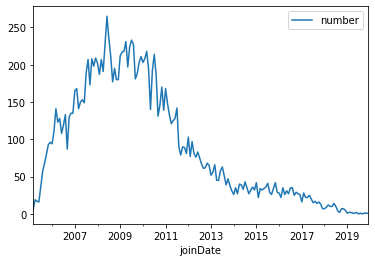

In [93]:
#使用pandas中统一的接口plot()来画图
userJoinMonth.plot.line()

#### 注意：ARIMA 模型对时间序列的要求是平稳型。因此，当你得到一个非平稳的时间序列时，首先要做的即是做时间序列的差分，得到一个平稳时间序列。

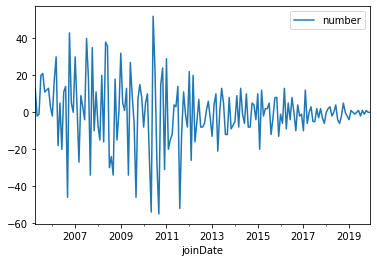

In [130]:
#差分–转换为平稳序列
user_diff = userJoinMonth.diff()
user_diff = user_diff.dropna()
user_diff.plot.line()

In [131]:
user_diff

,number
joinDate,
2005-04-01,13.0
2005-05-01,-2.0
2005-06-01,-1.0
2005-07-01,20.0
2005-08-01,21.0
...,...
2019-08-01,1.0
2019-09-01,-1.0
2019-10-01,1.0


### 由acf，pacf判断模型参数

C:\Users\ARCHER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.
C:\Users\ARCHER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


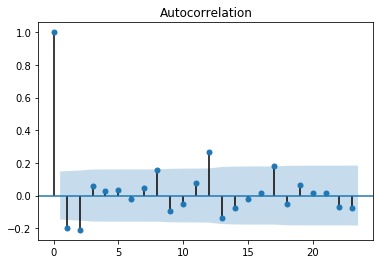

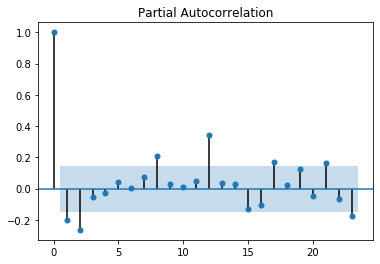

In [132]:
plot_acf(user_diff).show()
plot_pacf(user_diff).show()

自相关图显示滞后1阶自相关值基本没有超过边界值，
虽然有几个自相关值超出边界，那么很可能属于偶然出现的，而自相关值在其他上都没有超出显著边界。  
p选1；  
和上面一样的道理，q值选1。

### 训练模型

1493.9960225901073 1506.7006215204026 1499.1485144702742


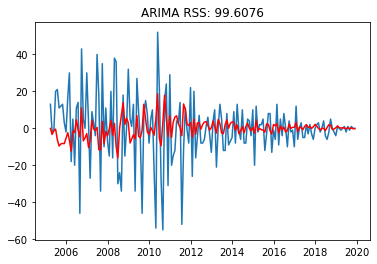

In [133]:
arima = ARIMA(userJoinMonth, order=(1, 1, 1))
result = arima.fit(disp=False)
print(result.aic, result.bic, result.hqic)

plt.plot(user_diff)
plt.plot(result.fittedvalues, color='red')
plt.title('ARIMA RSS: %.4f' % sum(result.fittedvalues - user_diff['number']) ** 2)
plt.show()


### 预测结果
#### 显示从2018-01-01开始的用户月增长数，2020-01-01之后的值为预测值

2020-01-01    0.846274
2020-02-01    0.757345
2020-03-01    0.684185
2020-04-01    0.614862
2020-05-01    0.546474
2020-06-01    0.478313
2020-07-01    0.410208
2020-08-01    0.342116
2020-09-01    0.274027
2020-10-01    0.205939
2020-11-01    0.137851
2020-12-01    0.069763
Freq: MS, dtype: float64


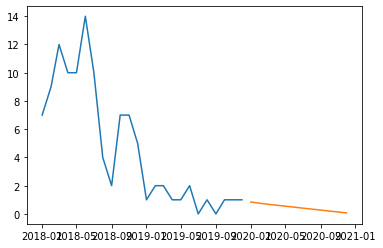

End


In [134]:
# 模型预测
pred = result.predict('20200101', '20201201', typ='levels')
print(pred)
x = pd.date_range('20180101', '20191201', freq='MS')
plt.plot(x[:24], userJoinMonth[-24:])
# lenth = len()
plt.plot(pred)
plt.show()
print('End')

### 观察结果：
新用户增长量持续走低